In [1]:
import time
import torch
from torch.distributions import Categorical, kl
from d2l.torch import Animator

from net import Net
from aco import ACO
from utils import *

lr = 3e-4
EPS = 1e-10
device = 'cuda:0'

max_len = {
    100: 4,
    200: 5,
    300: 6
}

In [2]:
def train_instance(model, optimizer, n, k_sparse, n_ants):
    model.train()
    coor = torch.rand(size=(n, 2), device=device)
    pyg_data, distances, prizes = gen_pyg_data(coor, k_sparse)
    heu_vec = model(pyg_data)
    heu_mat = model.reshape(pyg_data, heu_vec) + EPS
    aco = ACO(distances, prizes, max_len[n], n_ants, heuristic=heu_mat, device=device)
    objs, log_probs = aco.sample()
    baseline = objs.mean()
    reinforce_loss = torch.sum((baseline-objs) * log_probs.sum(dim=0)) / aco.n_ants
    optimizer.zero_grad()
    reinforce_loss.backward()
    optimizer.step()

def infer_instance(model, instance, k_sparse, n_ants):
    model.eval()
    pyg_data, distances, prizes = instance
    heu_mat = model.reshape(pyg_data, model(pyg_data)) + EPS
    aco = ACO(distances, prizes, max_len[len(prizes)], n_ants, heuristic=heu_mat, device=device)
    objs, log_probs_list = aco.sample()
    baseline = objs.mean()
    best_sample_obj = objs.max()
    return baseline.item(), best_sample_obj.item()

In [3]:
def train_epoch(n, n_ants, k_sparse, steps_per_epoch, net, optimizer):
    for _ in range(steps_per_epoch):
        train_instance(net, optimizer, n, k_sparse, n_ants)

@torch.no_grad()
def validation(n_ants, k_sparse, epoch, net, val_dataset, animator=None):
    sum_bl, sum_sample_best = 0, 0
    for instance in val_dataset:
        bl, sample_best = infer_instance(net, instance, k_sparse, n_ants)
        sum_bl += bl
        sum_sample_best += sample_best

    n_val = len(val_dataset)
    avg_bl, avg_sample_best = sum_bl/n_val, sum_sample_best/n_val
    if animator:
        animator.add(epoch+1, (avg_bl, avg_sample_best))
    
    return avg_bl, avg_sample_best

In [4]:
def train(problem_size, k_sparse, n_ants, steps_per_epoch, epochs):
    net = Net().to(device)
    optimizer = torch.optim.AdamW(net.parameters(), lr=lr)
    val_list = load_val_dataset(problem_size, k_sparse, device)
    animator = Animator(xlabel='epoch', xlim=[0, epochs],
                        legend=["Avg. sample obj.", "Best sample obj."])
    
    avg_bl, avg_best = validation(n_ants, k_sparse, -1, net, val_list, animator)
    val_results = [(avg_bl, avg_best)]
    
    all_time_best = 0
    
    sum_time = 0
    for epoch in range(0, epochs):
        start = time.time()
        train_epoch(problem_size, n_ants, k_sparse, steps_per_epoch, net, optimizer)
        sum_time += time.time() - start
        avg_bl, avg_sample_best = validation(n_ants, k_sparse, epoch, net, val_list, animator)
        val_results.append((avg_bl, avg_sample_best))
        if avg_sample_best > all_time_best:
            all_time_best = avg_sample_best
            torch.save(net.state_dict(), f'../pretrained/op/op{problem_size}.pt')

    print('total training duration:', sum_time)
    
    for epoch in range(-1, epochs):
        print(f'epoch {epoch}:', val_results[epoch+1])

Learn heuristic for OP100:

total training duration: 226.39119291305542
epoch -1: (8.28824610710144, 12.31031312942505)
epoch 0: (13.902390193939208, 17.50556557973226)
epoch 1: (21.376953442891438, 24.837225596110027)
epoch 2: (24.694289461771646, 28.573340098063152)
epoch 3: (23.30154685974121, 27.623050689697266)
epoch 4: (25.06116288503011, 29.081174977620442)


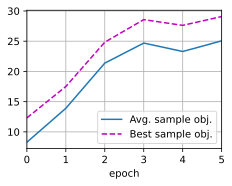

In [5]:
n_node, n_ants = 100, 20
steps_per_epoch = 64
k_sparse = 20
epochs = 5
train(n_node, k_sparse, n_ants, steps_per_epoch, epochs)

Learn heuristic for OP200:

total training duration: 350.6021296977997
epoch -1: (9.869989585876464, 13.899323145548502)
epoch 0: (20.763727347056072, 25.872632662455242)
epoch 1: (29.928150749206544, 36.152744166056316)
epoch 2: (31.543524106343586, 37.411222044626875)
epoch 3: (37.38984438578288, 43.43372389475505)
epoch 4: (38.33694082895915, 43.88097648620605)


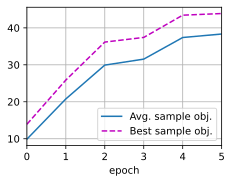

In [6]:
n_node, n_ants = 200, 20
steps_per_epoch = 64
k_sparse = 50
epochs = 5
train(n_node, k_sparse, n_ants, steps_per_epoch, epochs)

Learn heuristic for OP300:

total training duration: 401.9702386856079
epoch -1: (14.679882494608561, 21.019329770406088)
epoch 0: (22.294621340433757, 26.73596623738607)
epoch 1: (52.14308230082194, 58.727892557779946)
epoch 2: (60.42030982971191, 70.1949966430664)
epoch 3: (60.498954645792644, 70.69505437215169)
epoch 4: (58.77180773417155, 70.11100680033366)


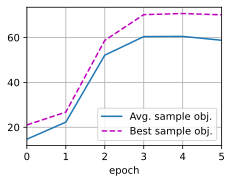

In [7]:
n_node, n_ants = 300, 20
steps_per_epoch = 64
k_sparse = 50
epochs = 5
train(n_node, k_sparse, n_ants, steps_per_epoch, epochs)